In [94]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from math import sqrt
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from vecstack import stacking

In [95]:
df = pd.read_csv(r'C:/Users/Venom/Desktop/694560_1215964_bundle_archive/preprocessed_data.csv')

In [96]:
df.shape

(2758800, 12)

In [97]:
df.columns

Index(['Region', 'Country', 'City', 'Month', 'Day', 'Year', 'AvgTemperature',
       'Latitude', 'Longitude', 'dist_from_north', 'dist_from_south', 'Date'],
      dtype='object')

In [98]:
df.Date.max(),df.Date.min()

('2019-12-31', '1995-01-01')

In [99]:
df.shape

(2758800, 12)

In [100]:
df.dtypes

Region              object
Country             object
City                object
Month                int64
Day                  int64
Year                 int64
AvgTemperature     float64
Latitude           float64
Longitude          float64
dist_from_north    float64
dist_from_south    float64
Date                object
dtype: object

In [101]:
#yyyy-mm-dd

In [102]:
df['Date'] = pd.to_datetime(df['Date'])

In [103]:
df.Date.quantile(0),df.Date.quantile(1)

(Timestamp('1995-01-01 00:00:00'), Timestamp('2019-12-31 00:00:00'))

In [104]:
def train_test_split(data,column,train_start_date, train_end_date,test_start_date,test_end_date):
    train_start_date = pd.to_datetime(train_start_date)
    train_end_date =  pd.to_datetime(train_end_date)
    test_start_date =  pd.to_datetime(test_start_date)
    test_end_date = pd.to_datetime(test_end_date)
    data[column] = pd.to_datetime(data[column])
    train = data.loc[(data[column]>=train_start_date)&(data[column]<=train_end_date)]
    test = data.loc[(data[column]>=test_start_date)&(data[column]<=test_end_date)]
    train.reset_index(drop =True,inplace = True)
    test.reset_index(drop =True,inplace = True)
    return train,test
def get_mape(actual, predicted):
    y_true, y_pred = np.array(actual), np.array(predicted)
    return np.round( np.mean(np.abs((actual - predicted)/ actual)) * 100, 2)

In [105]:
df['prev_day'] = df.groupby('City').AvgTemperature.shift(1)
df['prev_2day'] = df.groupby('City').AvgTemperature.shift(2)
df['prev_3day'] = df.groupby('City').AvgTemperature.shift(3)
df['prev_year'] = df.groupby('City').AvgTemperature.shift(365)
df['prev_2year'] = df.groupby('City').AvgTemperature.shift(365*2)
df['prev_3year'] = df.groupby('City').AvgTemperature.shift(365*3)

In [106]:
df['Season'] = (df.Month%12 + 3)//3

In [107]:
x_train,x_test = train_test_split(df[(df.Region!='North America')].copy().copy(),'Date','1995-01-01','2019-12-31','2020-01-01','2020-01-01')

In [108]:
x_train.shape,x_test.shape

((1250024, 19), (0, 19))

In [109]:
cat = [i for i in x_train.columns if x_train[i].dtypes=='object']

In [110]:
cat

['Region', 'Country', 'City']

In [111]:
region_temp_mapper = x_train.groupby('Region').AvgTemperature.mean().to_dict()
country_temp_mapper =  x_train.groupby('Country').AvgTemperature.mean().to_dict()
city_temp_mapper =  x_train.groupby('City').AvgTemperature.mean().to_dict()

In [112]:
x_train['Region_enc'] = x_train['Region'].map(region_temp_mapper)
x_test['Region_enc'] = x_test['Region'].map(region_temp_mapper)

x_train['Country_enc'] = x_train['Country'].map(country_temp_mapper)
x_test['Country_enc'] = x_test['Country'].map(country_temp_mapper)

x_train['City_enc'] = x_train['City'].map(city_temp_mapper)
x_test['City_enc'] = x_test['City'].map(city_temp_mapper)

In [113]:
x_train['is_neg_percent'] = np.where(x_train.AvgTemperature<0,1,0)
neg_mapper = x_train.groupby('City').apply(lambda x:x.is_neg_percent.mean()*100).to_dict()
x_train['is_neg_percent'] = x_train['City'].map(neg_mapper)
x_test['is_neg_percent'] = x_test['City'].map(neg_mapper)

In [114]:
x_train['combined'] = x_train.Country.astype(str)+"_"+x_train.Month.astype(str)
country_month_details = x_train.groupby(['combined']).AvgTemperature.mean().to_dict()
x_train['country_month_mean'] = x_train.combined.map(country_month_details)

x_test['combined'] = x_test.Country.astype(str)+"_"+x_test.Month.astype(str)
x_test['country_month_mean'] = x_test.combined.map(country_month_details)


In [115]:
x_train['combined'] = x_train.City.astype(str)+"_"+x_train.Season.astype(str)
city_season_details = x_train.groupby(['combined']).AvgTemperature.mean().to_dict()
x_train['city_season_mean'] = x_train.combined.map(city_season_details)

x_test['combined'] = x_test.City.astype(str)+"_"+x_test.Season.astype(str)
x_test['city_season_mean'] = x_test.combined.map(city_season_details)


In [116]:
x_train['combined'] = x_train.City.astype(str)+"_"+x_train.Month.astype(str)
city_month_details = x_train.groupby(['combined']).AvgTemperature.mean().to_dict()
x_train['city_month_mean'] = x_train.combined.map(city_month_details)

x_test['combined'] = x_test.City.astype(str)+"_"+x_test.Month.astype(str)
x_test['city_month_mean'] = x_test.combined.map(city_month_details)


In [117]:
x_train.drop('combined',inplace=True,axis = 1)
x_test.drop('combined',inplace=True,axis = 1)

In [118]:
x_train['days_rolling_mean'] = x_train.groupby('City')['AvgTemperature'].rolling(30).mean().reset_index(0,drop=True)
rolling_mean_mapper = x_train.groupby('City').days_rolling_mean.mean().to_dict()
x_test['days_rolling_mean'] = x_test['City'].map(rolling_mean_mapper)

In [119]:
x_train['years_rolling_mean'] = x_train.groupby('City')['AvgTemperature'].rolling(365).mean().reset_index(0,drop=True)
rolling_mean_mapper = x_train.groupby('City').years_rolling_mean.mean().to_dict()
x_test['years_rolling_mean'] = x_test['City'].map(rolling_mean_mapper)

In [120]:
y_train = x_train.AvgTemperature
y_test = x_test.AvgTemperature

In [121]:
x_train.columns

Index(['Region', 'Country', 'City', 'Month', 'Day', 'Year', 'AvgTemperature',
       'Latitude', 'Longitude', 'dist_from_north', 'dist_from_south', 'Date',
       'prev_day', 'prev_2day', 'prev_3day', 'prev_year', 'prev_2year',
       'prev_3year', 'Season', 'Region_enc', 'Country_enc', 'City_enc',
       'is_neg_percent', 'country_month_mean', 'city_season_mean',
       'city_month_mean', 'days_rolling_mean', 'years_rolling_mean'],
      dtype='object')

In [122]:
selected = ['Month', 'Longitude', 'dist_from_north', 'prev_year','prev_2year','prev_3year','city_month_mean',
            'days_rolling_mean','years_rolling_mean','is_neg_percent','city_season_mean']
len(selected)

11

In [123]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((1250024, 28), (0, 28), (1250024,), (0,))

In [124]:
x_train.Date.max()-x_train.Date.min(),x_test.Date.max()-x_test.Date.min()

(Timedelta('9130 days 00:00:00'), NaT)

In [125]:
x_train.columns

Index(['Region', 'Country', 'City', 'Month', 'Day', 'Year', 'AvgTemperature',
       'Latitude', 'Longitude', 'dist_from_north', 'dist_from_south', 'Date',
       'prev_day', 'prev_2day', 'prev_3day', 'prev_year', 'prev_2year',
       'prev_3year', 'Season', 'Region_enc', 'Country_enc', 'City_enc',
       'is_neg_percent', 'country_month_mean', 'city_season_mean',
       'city_month_mean', 'days_rolling_mean', 'years_rolling_mean'],
      dtype='object')

In [126]:
model = lgb.LGBMRegressor(n_estimators=500, max_depth=5,learning_rate=0.01)
x_train['weights'] = np.where(x_train.AvgTemperature<20,3,1)
model.fit(x_train[selected].fillna(0,axis = 1),y_train,x_train['weights'] )

LGBMRegressor(learning_rate=0.01, max_depth=5, n_estimators=500)

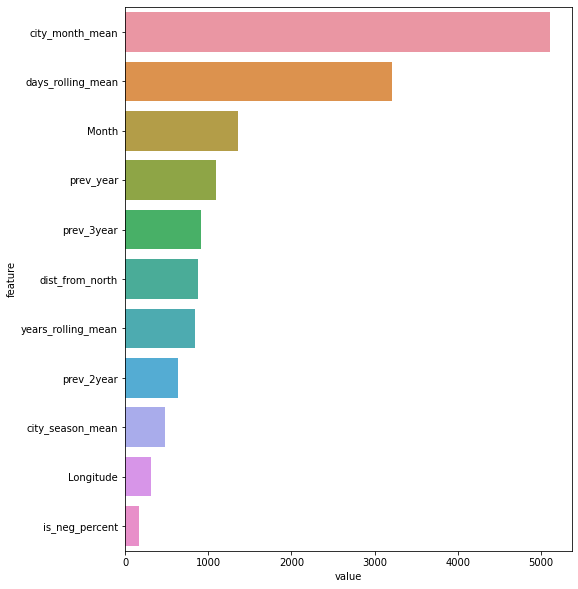

In [127]:
feat_importance = pd.DataFrame()
feat_importance["feature"] = selected
feat_importance["value"] = model.feature_importances_
feat_importance.sort_values(by='value', ascending=False, inplace=True)

plt.figure(figsize=(8,10))
ax = sns.barplot(y="feature", x="value", data=feat_importance)

In [128]:
import joblib

In [129]:
joblib.dump(model,"model.pkl")

['model.pkl']

In [130]:
temp = {'City': 'Lansing', 'Date': '2020-07-08 00:00:00', 'Day': 8, 'Month': 7, 'Year': 2020, 'Season': 3}

In [131]:
city_agg = pd.read_csv(r'C:\Users\Venom\Desktop\694560_1215964_bundle_archive\agg\city_agg.csv')
city_month_agg = pd.read_csv(r'C:\Users\Venom\Desktop\694560_1215964_bundle_archive\agg\city_month_agg.csv')
city_season_agg = pd.read_csv(r'C:\Users\Venom\Desktop\694560_1215964_bundle_archive\agg\city_season_agg.csv')
ymd_agg = pd.read_csv(r'C:\Users\Venom\Desktop\694560_1215964_bundle_archive\agg\ymd_agg.csv')

In [132]:
ymd_agg[(ymd_agg.City==temp['City'])&(ymd_agg.Month==temp['Month'])&(ymd_agg.Day==temp['Day'])&(ymd_agg.Year==(temp['Year']-1))]['AvgTemperature'].iloc[0]

66.5

In [133]:
temp['City']

'Lansing'

In [138]:
ze = ymd_agg[(ymd_agg.Year==2019)]

In [139]:
ze[(ze.AvgTemperature==ze.AvgTemperature.min())]

,City,Year,Month,Day,AvgTemperature
2749998,Fairbanks,2019,1,12,-38.5
